# Imports

In [20]:
import matplotlib.pyplot as plt
import optuna
import pandas as pd
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split

from src.preprocessing import preprocess_data
from src.utils.compute_metrics import compute_and_store_metrics
from src.utils.confusion_matrix import plot_confusion_matrix
from src.utils.load_data import load_data
from src.utils.save_model import save_model


AttributeError: module 'constants.paths' has no attribute 'MODELS_DIR'

# Load Data

In [9]:
X, y = preprocess_data(load_data())

# Model

## Basic Random Forest Classifier

In [10]:
## Train Test Split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

In [11]:
rfc = RandomForestClassifier(random_state=42)
rfc.fit(X_train, y_train)
y_pred = rfc.predict(X_test)

### Evaluation

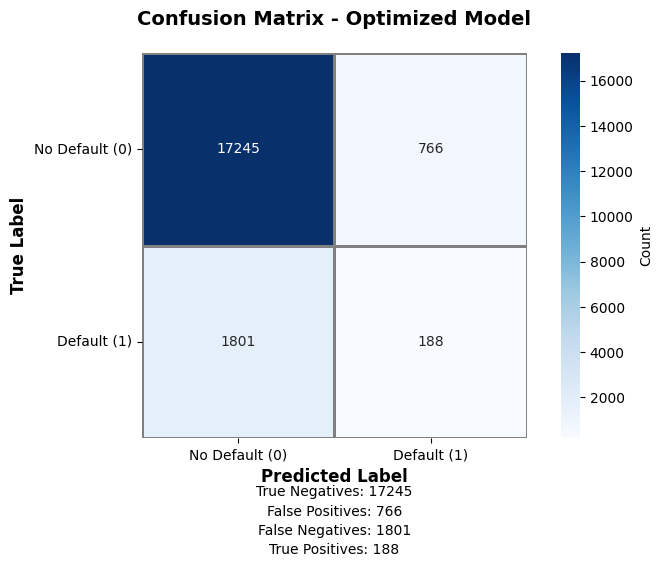


Model Metrics:
Accuracy:  0.8717 (87.17%)
Precision: 0.1971 (19.71%)
Recall:    0.0945 (9.45%)
F1-Score:  0.1278 (12.78%)


In [12]:
plot_confusion_matrix(y_test, y_pred, cmap="Blues")

## Hyperparameter fine-tuning (Optuna)

In [13]:
def objective(trial):
    # Suggest hyperparameters
    n_estimators = trial.suggest_int("n_estimators", 50, 300)
    max_depth = trial.suggest_int("max_depth", 5, 30)
    max_features = trial.suggest_float("max_features", 0.1, 1.0)
    class_weight = trial.suggest_categorical(
        "class_weight", [None, "balanced", "balanced_subsample"]
    )
    threshold = trial.suggest_float("threshold", 0.1, 0.9)

    # Create the model with suggested hyperparameters
    model = RandomForestClassifier(
        n_estimators=n_estimators,
        max_depth=max_depth,
        max_features=max_features,
        class_weight=class_weight,
    )

    # Train the model
    model.fit(X_train, y_train)

    # Make predictions
    y_pred_proba = model.predict_proba(X_test)[
        :, 1
    ]  # Probability estimates for the positive class (default)
    y_pred = (y_pred_proba >= threshold).astype(int)

    # Calculate F1-score (or any other metric you prefer)
    from sklearn.metrics import f1_score

    score = f1_score(y_test, y_pred)

    return score


# Create and run the study
study = optuna.create_study(direction="maximize")  # We want to maximize F1-score
study.optimize(objective, n_trials=50, show_progress_bar=True)

print("\n" + "=" * 60)
print("BEST HYPERPARAMETERS")
print("=" * 60)
print(f"Best F1-Score: {study.best_value:.4f}")
print(f"\nBest Parameters:")
for key, value in study.best_params.items():
    print(f"  {key}: {value}")

[I 2025-10-15 15:49:29,113] A new study created in memory with name: no-name-742e0826-2a82-4f4d-82d0-a666c11a7f0c


  0%|          | 0/50 [00:00<?, ?it/s]

[I 2025-10-15 15:50:11,884] Trial 0 finished with value: 0.26967528893780957 and parameters: {'n_estimators': 267, 'max_depth': 19, 'max_features': 0.8982132387925331, 'class_weight': 'balanced_subsample', 'threshold': 0.31491103274471655}. Best is trial 0 with value: 0.26967528893780957.
[I 2025-10-15 15:50:17,760] Trial 1 finished with value: 0.2672897196261682 and parameters: {'n_estimators': 50, 'max_depth': 16, 'max_features': 0.7267299314932044, 'class_weight': 'balanced', 'threshold': 0.37609249458488514}. Best is trial 0 with value: 0.26967528893780957.
[I 2025-10-15 15:50:25,792] Trial 2 finished with value: 0.1423487544483986 and parameters: {'n_estimators': 105, 'max_depth': 28, 'max_features': 0.1904826397048809, 'class_weight': 'balanced', 'threshold': 0.653277170756623}. Best is trial 0 with value: 0.26967528893780957.
[I 2025-10-15 15:50:49,097] Trial 3 finished with value: 0.1667217995368839 and parameters: {'n_estimators': 197, 'max_depth': 23, 'max_features': 0.580891

In [16]:
# Train the final model with best parameters
best_params = study.best_params

model = RandomForestClassifier(
    n_estimators=best_params["n_estimators"],
    max_depth=best_params["max_depth"],
    max_features=best_params["max_features"],
    class_weight=best_params["class_weight"],
)
model.fit(X_train, y_train)
y_pred_proba = model.predict_proba(X_test)[:, 1]
y_pred = (y_pred_proba >= best_params["threshold"]).astype(int)

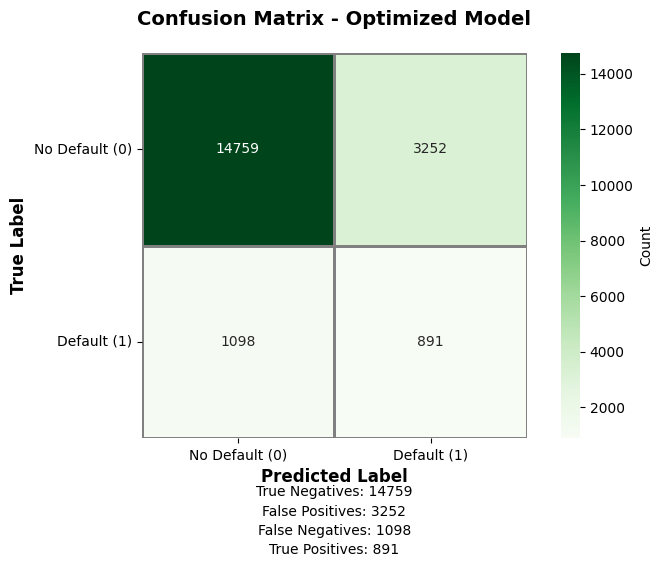


Model Metrics:
Accuracy:  0.7825 (78.25%)
Precision: 0.2151 (21.51%)
Recall:    0.4480 (44.80%)
F1-Score:  0.2906 (29.06%)


In [17]:
plot_confusion_matrix(y_test, y_pred, cmap="Greens")

In [18]:
compute_and_store_metrics(y_test, y_pred, model_name="Random Forest")

In [19]:
save_model(model, model_name="random_forest")

NameError: name 'save_model' is not defined